In [1]:
# import library
import numpy as np
import pandas as pd
import itertools
import os
import glob 
# from astropy.stats import sigma_clip

from tqdm import tqdm

set some parameters

In [2]:
# define file path
path_folder = './../autodl-tmp/'
path_out = './../autodl-tmp/data_raw/'

if not os.path.exists(path_out):
    os.makedirs(path_out)
    print(f"Directory {path_out} created.")
else:
    print(f"Directory {path_out} already exists.")

Directory ./../autodl-tmp/data_raw/ already exists.


In [3]:
# set chunk size to avoid exceeding the memory capacity
CHUNKS_SIZE = 4

step 1: analog-to-digital conversion

In [4]:
def ADC_convert(signal, gain, offset):
    """
    Converts ADC (Analog-to-Digital Converter) signals to actual values.

    This function is used to convert digital signals obtained from an ADC to their corresponding physical values based on the gain and offset.

    Parameters:
    - signal: Array of digital signals obtained from the ADC.
    - gain: Gain value used to scale the signal intensity back to its actual value.
    - offset: Offset value used to adjust the signal to the correct measurement range.

    Returns:
    - Corrected signal array representing the actual physical values.
    """
    # Convert the signal to floating-point numbers to improve precision
    signal = signal.astype(np.float64)
    
    # Divide the signal by the gain to restore the signal intensity
    signal /= gain
    
    # Add the offset to adjust the signal to the correct measurement range
    signal += offset
    
    # Return the corrected signal
    return signal

step 2: readout noise correction

In [5]:
def readout_correct(signal, read_noise):
    """
    Subtract readout noise from the signal.

    Parameters:
    - signal: Signal array from which readout noise is to be subtracted.
    - read_noise: Readout noise array to be subtracted from the signal array.

    Returns:
    - signal_readout: Signal array after subtracting readout noise.
    """
    # Tile the readout noise array to match the dimensions of the signal array.
    read_noise = np.tile(read_noise, (signal.shape[0], 1, 1))
    # Subtract readout noise from the signal.
    signal_readout = signal - read_noise
    return signal_readout

step 3: Mask hot/dead pixel

In [6]:
def mask_hot_dead(signal, dead, dark, maxiters=5, sigma=5):
    '''
    This function identifies and masks hot and dead pixels in the input signal.

    Parameters:
    - signal: The primary input data, typically raw signals collected from astronomical instruments (like images or time series data). The shape of the signal matrix is usually (time, height, width), representing images at different times (or multiple frames).

    - dead: A matrix indicating dead pixels. This matrix marks which pixels in the sensor are dead (i.e., do not respond to light signals). The shape of the dead matrix should match a single frame image, typically (height, width).

    - dark: Represents "dark frame" data. Dark frames are measured under no-light conditions to capture hot pixels or other electronic noise in the detector. The shape of the dark matrix also matches a single frame image.
    
    Returns:
    - signal: The processed signal with hot and dead pixels masked.
    '''
    # Initialize hot pixel mask as a boolean array of False (no pixels masked initially)
    hot_mask = np.zeros_like(dark, dtype=bool)
    
    # Iteratively mask values that exceed the sigma threshold
    for _ in range(maxiters):
        # Calculate mean and standard deviation of unmasked values
        mean_dark = np.mean(dark[~hot_mask])
        std_dark = np.std(dark[~hot_mask])
        
        # Find new hot pixels exceeding the sigma threshold
        new_mask = np.abs(dark - mean_dark) > sigma * std_dark
        
        # Update hot_mask to include newly detected hot pixels
        hot_mask |= new_mask  # Use bitwise OR to accumulate masks
        
        # If no new pixels are being masked, stop iterating
        if not np.any(new_mask):
            break
    # Extend the hot and dead pixel masks across the entire time dimension to match the shape of the signal
    hot = np.tile(hot_mask, (signal.shape[0], 1, 1))
    dead = np.tile(dead, (signal.shape[0], 1, 1))
    # Mask dead and hot pixels
    signal = np.ma.masked_where(dead, signal)
    signal = np.ma.masked_where(hot, signal)
    return signal

step 4: linearity correction

In [7]:
def apply_linear_corr(linear_corr, clean_signal):
    """
    Apply linear correction to the clean signal.

    Parameters:
    linear_corr: Array of polynomial correction coefficients, where each row corresponds to a polynomial's coefficients.
    clean_signal: Original signal data, a three-dimensional array where the first dimension represents the signal sequence, and the last two dimensions represent the image's two-dimensional pixel coordinates.

    Returns:
    Corrected signal.
    """
    # Reverse the linear_corr array along the first dimension
    # This is because the coefficients in np.poly1d are ordered from highest degree to lowest, while the linear_corr array stores them in reverse order
    linear_corr = np.flip(linear_corr, axis=0)
    
    # Generate coordinate pairs (x, y) for each pixel in the image and iterate through each pixel
    # This is to apply polynomial correction to each pixel individually
    for x, y in itertools.product(
                range(clean_signal.shape[1]), range(clean_signal.shape[2])
            ):
        # For each pixel (x, y), extract the corresponding polynomial coefficients linear_corr[:, x, y], and construct a polynomial function poli using np.poly1d
        # This converts the polynomial coefficients into an evaluable polynomial function
        poli = np.poly1d(linear_corr[:, x, y])
        
        # Apply the polynomial poli to the original signal clean_signal[:, x, y] and replace the original signal with the corrected result
        # This directly replaces the original signal data with the output of the polynomial function, achieving the correction
        clean_signal[:, x, y] = poli(clean_signal[:, x, y])
    
    # Return the corrected signal
    return clean_signal

step 5: dark current subtraction

In [8]:
def clean_dark(signal, dead, dark, dt):
    """
    Subtract dark current from the given signal, handling dead pixels.

    Parameters:
    signal: ndarray, observed signal to be corrected for dark current.
    dead: ndarray, mask array indicating dead pixels, used to mask out dead pixels in dark current data.
    dark: ndarray, dark current data, used to correct the signal.
    dt: ndarray, array of time differences, used to adjust the contribution of dark current.

    Returns:
    ndarray, corrected signal with dark current removed.
    """
    # Mask out dead pixels in the dark current data
    dark = np.ma.masked_where(dead, dark)
    # Tile the dark data along the time axis to match the shape of the signal.
    dark = np.tile(dark, (signal.shape[0], 1, 1))
    # Subtract the dark current from the observed signal.
    signal -= dark * dt[:, np.newaxis, np.newaxis]  # Extend the shape of dt to enable broadcasting across the spatial dimensions of the signal.
    return signal

step 6: get correlated double sampling

In [9]:
def get_cds(signal):
    """
    Calculate and return the differential signal (CDS).

    The CDS is computed by taking the difference between the odd and even columns of the input signal.
    This method is commonly used in image processing and signal processing to capture local changes in the signal.

    Parameters:
    signal (ndarray): A four-dimensional array representing the input signal. The second dimension is interpreted as rows,
                      where odd and even columns are subtracted to compute the differential signal.

    Returns:
    ndarray: An array containing the computed differential signal (CDS). The returned array has the same dimensions as the
             input signal, except that the second dimension is halved because each pair of columns is combined to compute a single difference.
    """
    # Compute the differential signal by subtracting even columns from odd columns
    cds = signal[:,1::2,:,:] - signal[:,::2,:,:]
    return cds

step 7: flat field correction

In [10]:
def correct_flat_field(flat, dead, signal):
    '''
    Function to perform flat field correction.
    Flat field correction aims to correct the non-uniform response of each pixel in the detector, improving the accuracy of the observed signal.
    
    Parameters:
    flat: Flat field image representing the response differences of each pixel in the detector.
    dead: Mask for dead pixels, identifying failed or abnormal pixels (e.g., pixels that do not respond normally).
    signal: Original observed signal that needs correction.
    
    Returns:
    Corrected observed signal.
    '''
    # Transpose the flat field and dead pixel images for subsequent processing
    # flat = flat.transpose(1, 0)
    # dead = dead.transpose(1, 0)
    
    # Mask the flat field image to ignore the effect of dead pixels
    flat = np.ma.masked_where(dead, flat)
    
    # Expand the flat field image along the time dimension to match the signal dimensions
    flat = np.tile(flat, (signal.shape[0], 1, 1))
    
    # Perform flat field correction to remove non-uniform pixel responses
    signal = signal / flat
    # The flat field contains the response coefficients of each pixel, and this step eliminates the non-uniform response of different pixels, resulting in a more accurate signal.
    
    return signal

step 8: time binning

In [11]:
def bin_obs(signal, binning):
    '''
    Performs time binning on the signal data processed by Correlated Double Sampling (CDS).

    Parameters:
    cds_signal: The input signal data after Correlated Double Sampling, with shape (time, height, width).
    binning: The stride for time binning, indicating how many time steps are merged into one.

    Returns:
    Binned signal data with reduced time steps and unchanged dimensions.
    '''
    # height*width -> width*height
    signal_transposed = signal.transpose(0,1,3,2)
    
    # Create a new empty array `cds_binned` to store the binned signal data,
    # reducing the time dimension length by a factor of 1/binning since multiple time steps are merged.
    # Other dimensions remain unchanged.
    signal_binned = np.zeros((signal_transposed.shape[0], signal_transposed.shape[1]//binning, signal_transposed.shape[2], signal_transposed.shape[3]))
    
    # Iterate over each new time step `i`
    for i in range(signal_transposed.shape[1]//binning):
        # Select `binning` consecutive time steps using i*binning:(i+1)*binning and merge them.
        # np.sum(..., axis=1) sums these time steps along the time dimension, achieving time binning.
        signal_binned[:,i,:,:] = np.sum(signal_transposed[:,i*binning:(i+1)*binning,:,:], axis=1)
    
    # Return the binned signal data with reduced time steps and unchanged dimensions
    return signal_binned

calibrating all training data

In [12]:
# get the index of training data
def get_index(files, CHUNKS_SIZE):
    index = []
    for file in files:
        file_name = file.split('/')[-1]
        if file_name.split('_')[0] == 'AIRS-CH0' and file_name.split('_')[1] == 'signal.parquet':
            # file index is exoplanet ID
            file_index = os.path.basename(os.path.dirname(file))
            index.append(int(file_index))
    index = np.array(index)
    index = np.sort(index) 
    # divide based on chunks size
    index=np.array_split(index, len(index)//CHUNKS_SIZE)

    return index

In [13]:
# conduct the process of calibration

files = glob.glob(os.path.join(path_folder + 'train/', '*/*'))

index = get_index(files[:], CHUNKS_SIZE)  # get the entire dataset

train_adc_info = pd.read_csv(os.path.join(path_folder, 'train_adc_info.csv'))
train_adc_info = train_adc_info.set_index('planet_id')
axis_info = pd.read_parquet(os.path.join(path_folder,'axis_info.parquet'))
DO_READ = True # readout correction
DO_MASK = True  # mask dead and hot pixels
DO_THE_NL_CORR = False  # linear correction
DO_DARK = True # dark current correction
DO_FLAT = True  # flat correction
TIME_BINNING = True  # time binning

cut_inf, cut_sup = 39, 321  # cut along the wavelength axis between pixels 39 to 321
l = cut_sup - cut_inf

# deal with each data chunk
for n, index_chunk in enumerate(tqdm(index)):
    AIRS_CH0_clean = np.zeros((CHUNKS_SIZE, 11250, 32, l))
    FGS1_clean = np.zeros((CHUNKS_SIZE, 135000, 32, 32))
    
    # load signal and conduct ADC, readout, dark, flat, dead, linear correction
    for i in range (CHUNKS_SIZE) : 
        # deal with AIRS-CH0
        df = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_signal.parquet'))
        signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 356))
        gain = train_adc_info['AIRS-CH0_adc_gain'].loc[index_chunk[i]]
        offset = train_adc_info['AIRS-CH0_adc_offset'].loc[index_chunk[i]]
        signal = ADC_convert(signal, gain, offset)
        # dt_airs load signal integration time information
        dt_airs = axis_info['AIRS-CH0-integration_time'].dropna().values
        dt_airs[1::2] += 0.1
        chopped_signal = signal[:, :, cut_inf:cut_sup]
        del signal, df
        
        # clean AIRS data
        readout = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/read.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        dark = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/dark.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        dead_airs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/dead.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        linear_corr = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/linear_corr.parquet')).values.astype(np.float64).reshape((6, 32, 356))[:, :, cut_inf:cut_sup]
        
        if DO_READ:
            chopped_signal = readout_correct(chopped_signal, readout)
            AIRS_CH0_clean[i] = chopped_signal
        else:
            AIRS_CH0_clean[i] = chopped_signal
        del readout

        if DO_MASK:
            chopped_signal = mask_hot_dead(chopped_signal, dead_airs, dark)
            AIRS_CH0_clean[i] = chopped_signal
        else:
            AIRS_CH0_clean[i] = chopped_signal
            
        if DO_THE_NL_CORR: 
            linear_corr_signal = apply_linear_corr(linear_corr, AIRS_CH0_clean[i])
            AIRS_CH0_clean[i,:, :, :] = linear_corr_signal
        del linear_corr
        
        if DO_DARK: 
            cleaned_signal = clean_dark(AIRS_CH0_clean[i], dead_airs, dark, dt_airs)
            AIRS_CH0_clean[i] = cleaned_signal
        else: 
            pass
        del dark
        
        # deal with FGS1 signal
        df = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_signal.parquet'))
        fgs_signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 32))
        
        FGS1_gain = train_adc_info['FGS1_adc_gain'].loc[index_chunk[i]]
        FGS1_offset = train_adc_info['FGS1_adc_offset'].loc[index_chunk[i]]
        
        fgs_signal = ADC_convert(fgs_signal, FGS1_gain, FGS1_offset)
        dt_fgs1 = np.ones(len(fgs_signal))*0.1
        dt_fgs1[1::2] += 0.1
        chopped_FGS1 = fgs_signal
        del fgs_signal, df
        
        # clean FGS1 data
        readout = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/read.parquet')).values.astype(np.float64).reshape((32, 32))
        dark = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/dark.parquet')).values.astype(np.float64).reshape((32, 32))
        dead_fgs1 = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/dead.parquet')).values.astype(np.float64).reshape((32, 32))
        linear_corr = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/linear_corr.parquet')).values.astype(np.float64).reshape((6, 32, 32))
        
        if DO_READ:
            chopped_FGS1 = readout_correct(chopped_FGS1, readout)
            FGS1_clean[i] = chopped_FGS1
        else:
            FGS1_clean[i] = chopped_FGS1
        del readout
        
        if DO_MASK:
            chopped_FGS1 = mask_hot_dead(chopped_FGS1, dead_fgs1, dark)
            FGS1_clean[i] = chopped_FGS1
        else:
            FGS1_clean[i] = chopped_FGS1

        if DO_THE_NL_CORR: 
            linear_corr_signal = apply_linear_corr(linear_corr, FGS1_clean[i])
            FGS1_clean[i,:, :, :] = linear_corr_signal
        del linear_corr
        
        if DO_DARK: 
            cleaned_signal = clean_dark(FGS1_clean[i], dead_fgs1, dark, dt_fgs1)
            FGS1_clean[i] = cleaned_signal
        else: 
            pass
        del dark
        
    # CDS for whole chunk
    AIRS_cds = get_cds(AIRS_CH0_clean)
    FGS1_cds = get_cds(FGS1_clean)
    
    del AIRS_CH0_clean, FGS1_clean
    
    # flat field correction
    for i in range (CHUNKS_SIZE):
        flat_airs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        flat_fgs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 32))
        if DO_FLAT:
            corrected_AIRS_cds = correct_flat_field(flat_airs, dead_airs, AIRS_cds[i])
            AIRS_cds[i] = corrected_AIRS_cds
            corrected_FGS1_cds = correct_flat_field(flat_fgs, dead_fgs1, FGS1_cds[i])
            FGS1_cds[i] = corrected_FGS1_cds
        else:
            pass

    # Time Binning to reduce space
    if TIME_BINNING:
        AIRS_cds_binned = bin_obs(AIRS_cds,binning=30)
        FGS1_cds_binned = bin_obs(FGS1_cds,binning=30*12)
    else:
        AIRS_cds = AIRS_cds.transpose(0,1,3,2) ## this is important to make it consistent for flat fielding, but you can always change it
        AIRS_cds_binned = AIRS_cds
        FGS1_cds = FGS1_cds.transpose(0,1,3,2)
        FGS1_cds_binned = FGS1_cds
    
    del AIRS_cds, FGS1_cds
    
    
    ## save data
    np.save(os.path.join(path_out, 'AIRS_clean_train_{}.npy'.format(n)), AIRS_cds_binned)
    np.save(os.path.join(path_out, 'FGS1_clean_train_{}.npy'.format(n)), FGS1_cds_binned)
    del AIRS_cds_binned
    del FGS1_cds_binned

100%|██████████| 168/168 [4:43:59<00:00, 101.42s/it]]


In [14]:
# deal with the first chunk separately (the first chunk size is 5)
files = glob.glob(os.path.join(path_folder + 'train/', '*/*'))

index = get_index(files[:], CHUNKS_SIZE)  # get the entire dataset

train_adc_info = pd.read_csv(os.path.join(path_folder, 'train_adc_info.csv'))
train_adc_info = train_adc_info.set_index('planet_id')
axis_info = pd.read_parquet(os.path.join(path_folder,'axis_info.parquet'))
DO_READ = True # readout correction
DO_MASK = True  # mask dead and hot pixels
DO_THE_NL_CORR = False  # linear correction
DO_DARK = True # dark current correction
DO_FLAT = True  # flat correction
TIME_BINNING = True  # time binning

cut_inf, cut_sup = 39, 321  # cut along the wavelength axis between pixels 39 to 321
l = cut_sup - cut_inf

# deal with each data chunk
for n, index_chunk in enumerate(tqdm([index[0]])):
    AIRS_CH0_clean = np.zeros((5, 11250, 32, l))
    FGS1_clean = np.zeros((5, 135000, 32, 32))
    
    # load signal and conduct ADC, readout, dark, flat, dead, linear correction
    for i in range (5) : 
        # deal with AIRS-CH0
        df = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_signal.parquet'))
        signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 356))
        gain = train_adc_info['AIRS-CH0_adc_gain'].loc[index_chunk[i]]
        offset = train_adc_info['AIRS-CH0_adc_offset'].loc[index_chunk[i]]
        signal = ADC_convert(signal, gain, offset)
        # dt_airs load signal integration time information
        dt_airs = axis_info['AIRS-CH0-integration_time'].dropna().values
        dt_airs[1::2] += 0.1
        chopped_signal = signal[:, :, cut_inf:cut_sup]
        del signal, df
        
        # clean AIRS data
        readout = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/read.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        dark = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/dark.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        dead_airs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/dead.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        linear_corr = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/linear_corr.parquet')).values.astype(np.float64).reshape((6, 32, 356))[:, :, cut_inf:cut_sup]
        
        if DO_READ:
            chopped_signal = readout_correct(chopped_signal, readout)
            AIRS_CH0_clean[i] = chopped_signal
        else:
            AIRS_CH0_clean[i] = chopped_signal
        del readout

        if DO_MASK:
            chopped_signal = mask_hot_dead(chopped_signal, dead_airs, dark)
            AIRS_CH0_clean[i] = chopped_signal
        else:
            AIRS_CH0_clean[i] = chopped_signal
            
        if DO_THE_NL_CORR: 
            linear_corr_signal = apply_linear_corr(linear_corr, AIRS_CH0_clean[i])
            AIRS_CH0_clean[i,:, :, :] = linear_corr_signal
        del linear_corr
        
        if DO_DARK: 
            cleaned_signal = clean_dark(AIRS_CH0_clean[i], dead_airs, dark, dt_airs)
            AIRS_CH0_clean[i] = cleaned_signal
        else: 
            pass
        del dark
        
        # deal with FGS1 signal
        df = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_signal.parquet'))
        fgs_signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 32))
        
        FGS1_gain = train_adc_info['FGS1_adc_gain'].loc[index_chunk[i]]
        FGS1_offset = train_adc_info['FGS1_adc_offset'].loc[index_chunk[i]]
        
        fgs_signal = ADC_convert(fgs_signal, FGS1_gain, FGS1_offset)
        dt_fgs1 = np.ones(len(fgs_signal))*0.1
        dt_fgs1[1::2] += 0.1
        chopped_FGS1 = fgs_signal
        del fgs_signal, df
        
        # clean FGS1 data
        readout = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/read.parquet')).values.astype(np.float64).reshape((32, 32))
        dark = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/dark.parquet')).values.astype(np.float64).reshape((32, 32))
        dead_fgs1 = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/dead.parquet')).values.astype(np.float64).reshape((32, 32))
        linear_corr = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/linear_corr.parquet')).values.astype(np.float64).reshape((6, 32, 32))
        
        if DO_READ:
            chopped_FGS1 = readout_correct(chopped_FGS1, readout)
            FGS1_clean[i] = chopped_FGS1
        else:
            FGS1_clean[i] = chopped_FGS1
        del readout
        
        if DO_MASK:
            chopped_FGS1 = mask_hot_dead(chopped_FGS1, dead_fgs1, dark)
            FGS1_clean[i] = chopped_FGS1
        else:
            FGS1_clean[i] = chopped_FGS1

        if DO_THE_NL_CORR: 
            linear_corr_signal = apply_linear_corr(linear_corr, FGS1_clean[i])
            FGS1_clean[i,:, :, :] = linear_corr_signal
        del linear_corr
        
        if DO_DARK: 
            cleaned_signal = clean_dark(FGS1_clean[i], dead_fgs1, dark, dt_fgs1)
            FGS1_clean[i] = cleaned_signal
        else: 
            pass
        del dark
        
    # CDS for whole chunk
    AIRS_cds = get_cds(AIRS_CH0_clean)
    FGS1_cds = get_cds(FGS1_clean)
    
    del AIRS_CH0_clean, FGS1_clean
    
    # flat field correction
    for i in range (5):
        flat_airs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        flat_fgs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 32))
        if DO_FLAT:
            corrected_AIRS_cds = correct_flat_field(flat_airs, dead_airs, AIRS_cds[i])
            AIRS_cds[i] = corrected_AIRS_cds
            corrected_FGS1_cds = correct_flat_field(flat_fgs, dead_fgs1, FGS1_cds[i])
            FGS1_cds[i] = corrected_FGS1_cds
        else:
            pass

    # Time Binning to reduce space
    if TIME_BINNING:
        AIRS_cds_binned = bin_obs(AIRS_cds,binning=30)
        FGS1_cds_binned = bin_obs(FGS1_cds,binning=30*12)
    else:
        AIRS_cds = AIRS_cds.transpose(0,1,3,2) ## this is important to make it consistent for flat fielding, but you can always change it
        AIRS_cds_binned = AIRS_cds
        FGS1_cds = FGS1_cds.transpose(0,1,3,2)
        FGS1_cds_binned = FGS1_cds
    
    del AIRS_cds, FGS1_cds
    
    
    ## save data
    np.save(os.path.join(path_out, 'AIRS_clean_train_{}.npy'.format(n)), AIRS_cds_binned)
    np.save(os.path.join(path_out, 'FGS1_clean_train_{}.npy'.format(n)), FGS1_cds_binned)
    del AIRS_cds_binned
    del FGS1_cds_binned

100%|██████████| 1/1 [02:17<00:00, 137.83s/it]


combine all data into one dataset

In [15]:
def load_data (file, chunk_size, nb_files) : 
    data0 = np.load(file + '_0.npy')
    data_all = np.zeros((nb_files*chunk_size+1, data0.shape[1], data0.shape[2], data0.shape[3]))
    # the size of first chunk is 5
    data_all[:(chunk_size+1)] = data0
    for i in range (1, nb_files) : 
        data_all[(i*chunk_size+1):((i+1)*chunk_size+1)] = np.load(file + '_{}.npy'.format(i))
    return data_all 

data_train = load_data(path_out + 'AIRS_clean_train', CHUNKS_SIZE, len(index)) 
data_train_FGS = load_data(path_out + 'FGS1_clean_train', CHUNKS_SIZE, len(index))


In [16]:
np.save('./../autodl-tmp/data_raw_total/' + 'data_train_AIRS.npy', data_train)
np.save('./../autodl-tmp/data_raw_total/' + 'data_train_FGS.npy', data_train_FGS)

plot the data

In [17]:
import matplotlib.pyplot as plt 

print('Shape of the training datasset: \t')
print('\n For AIRS-CH0:', data_train.shape)
print('\n For FGS1:', data_train_FGS.shape)

Shape of the training datasset: 	

 For AIRS-CH0: (673, 187, 282, 32)

 For FGS1: (673, 187, 32, 32)


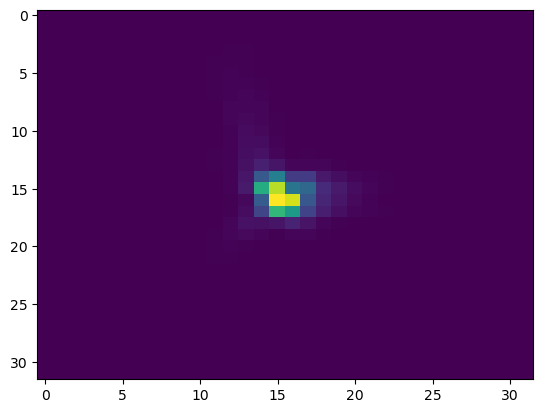

In [18]:
plt.imshow(data_train_FGS[6,51,:,:].T, aspect = 'auto')

Text(0, 0.5, 'Normalized flux in the frame')

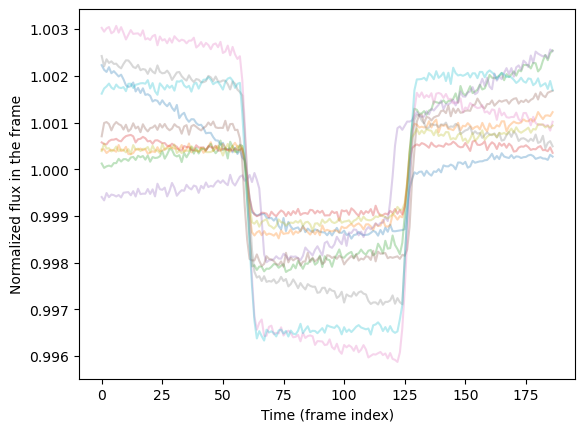

In [ ]:
for i in range(len(data_train[20:30])) : 
    light_curve = data_train[i,:,:,:].sum(axis=(1,2))
    plt.plot(light_curve/light_curve.mean(), '-', alpha=0.3)

plt.xlabel('Time (frame index)')
plt.ylabel('Normalized flux in the frame')